# Stock Market Prediction - Model Training

This notebook implements and evaluates various machine learning models for stock price prediction.

**Dataset**: 12 engineered features from 15 stocks (Sep 1 - Oct 15, 2025)

**Goals**:
1. Load processed features from feature engineering
2. Implement baseline models (Naive, Moving Average)
3. Train traditional ML models (Linear Regression, Random Forest, XGBoost)
4. Build deep learning models (LSTM, GRU)
5. Evaluate and compare model performance
6. Log experiments to MLflow

In [74]:
import sys
from pathlib import Path

# Add project root to path
sys.path.append(str(Path.cwd().parent))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import warnings

warnings.filterwarnings("ignore")

# Set plotting style
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

print("✅ Imports complete")

✅ Imports complete


## Load Processed Data

In [75]:
# Load processed features
data_path = Path("../data/processed/features_selected.parquet")

if not data_path.exists():
    print(f"❌ Data file not found: {data_path}")
    print("Please run 01_feature_engineering.ipynb first to generate the data.")
else:
    df = pd.read_parquet(data_path)
    print(f"✅ Loaded {len(df):,} records with {len(df.columns)} columns")
    print(f"\nColumns: {df.columns.tolist()}")
    print(f"\nStocks: {df['symbol'].unique()}")
    print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")

✅ Loaded 8,955 records with 15 columns

Columns: ['symbol', 'timestamp', 'low', 'close_lag_1', 'sma_5', 'ema_5', 'bb_upper', 'rsi', 'volatility_20d', 'returns', 'volume', 'volume_lag_1', 'market_cap', 'day_of_month', 'close_price']

Stocks: ['2222.SR' 'AAPL' 'AMZN' 'AVGO' 'BRK-B' 'GOOG' 'JPM' 'META' 'MSFT' 'NVDA'
 'TCEHY' 'TSLA' 'TSM' 'V' 'WMT']
Date range: 2025-09-03 10:12:12.591702+00:00 to 2025-10-15 07:12:03.959273+00:00


In [76]:
# Inspect data
df.head(10)

,symbol,timestamp,low,close_lag_1,sma_5,ema_5,bb_upper,rsi,volatility_20d,returns,volume,volume_lag_1,market_cap,day_of_month,close_price
0,2222.SR,2025-09-03 12:22:44.398221+00:00,23.56,23.66,23.678,23.654676,23.797289,13.636364,0.001031,-0.003804,1554566,782009.0,5.702941e+12,3,23.57
1,2222.SR,2025-09-03 13:21:51.638355+00:00,23.56,23.57,23.640,23.626451,23.812395,13.636364,0.001031,0.000000,1554566,1554566.0,5.707778e+12,3,23.57
2,2222.SR,2025-09-03 14:12:16.995202+00:00,23.56,23.57,23.610,23.607634,23.820982,13.636364,0.001031,0.000000,1554566,1554566.0,5.707778e+12,3,23.57
3,2222.SR,2025-09-03 15:13:15.466260+00:00,23.56,23.57,23.588,23.595089,23.825522,13.636364,0.001031,0.000000,1554566,1554566.0,5.707778e+12,3,23.57
4,2222.SR,2025-09-03 16:14:16.075692+00:00,23.56,23.57,23.570,23.586726,23.827090,13.636364,0.001031,0.000000,1554566,1554566.0,5.707778e+12,3,23.57
5,2222.SR,2025-09-03 17:10:12.449127+00:00,23.56,23.57,23.570,23.581151,23.826258,13.636364,0.001031,0.000000,1554566,1554566.0,5.707778e+12,3,23.57
6,2222.SR,2025-09-03 18:16:33.326476+00:00,23.56,23.57,23.570,23.577434,23.823361,13.636364,0.001031,0.000000,1554566,1554566.0,5.707778e+12,3,23.57
7,2222.SR,2025-09-03 19:09:48.905059+00:00,23.56,23.57,23.570,23.574956,23.818600,13.636364,0.001031,0.000000,1554566,1554566.0,5.707778e+12,3,23.57
8,2222.SR,2025-09-03 20:12:59.617181+00:00,23.56,23.57,23.570,23.573304,23.812090,13.636364,0.001031,0.000000,1554566,1554566.0,5.707778e+12,3,23.57
9,2222.SR,2025-09-03 21:10:34.615716+00:00,23.56,23.57,23.570,23.572203,23.803878,13.636364,0.001031,0.000000,1554566,1554566.0,5.707778e+12,3,23.57


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8955 entries, 0 to 8954
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   symbol          8955 non-null   object             
 1   timestamp       8955 non-null   datetime64[ns, UTC]
 2   low             8955 non-null   float64            
 3   close_lag_1     8955 non-null   float64            
 4   sma_5           8955 non-null   float64            
 5   ema_5           8955 non-null   float64            
 6   bb_upper        8955 non-null   float64            
 7   rsi             8955 non-null   float64            
 8   volatility_20d  8955 non-null   float64            
 9   returns         8955 non-null   float64            
 10  volume          8955 non-null   int64              
 11  volume_lag_1    8955 non-null   float64            
 12  market_cap      8955 non-null   float64            
 13  day_of_month    8955 non-null   i

## Train/Test Split

Using time-based split to maintain temporal ordering - critical for time series models.

In [78]:
# Sort by symbol and timestamp to ensure proper temporal ordering
df = df.sort_values(["symbol", "timestamp"]).reset_index(drop=True)

# Time-based split per stock (80/20) - maintains temporal order for EACH stock
train_list = []
test_list = []

for symbol in df["symbol"].unique():
    symbol_df = df[df["symbol"] == symbol].copy()
    split_idx = int(len(symbol_df) * 0.8)

    train_list.append(symbol_df.iloc[:split_idx])
    test_list.append(symbol_df.iloc[split_idx:])

train_df = pd.concat(train_list, ignore_index=True)
test_df = pd.concat(test_list, ignore_index=True)

print(f"Train set: {len(train_df):,} records")
print(f"  Date range: {train_df['timestamp'].min()} to {train_df['timestamp'].max()}")
print(f"  Stocks: {train_df['symbol'].nunique()}")
print(
    f"  Records per stock: {train_df.groupby('symbol').size().describe()[['min', 'max', 'mean']].to_dict()}"
)

print(f"\nTest set: {len(test_df):,} records")
print(f"  Date range: {test_df['timestamp'].min()} to {test_df['timestamp'].max()}")
print(f"  Stocks: {test_df['symbol'].nunique()}")
print(
    f"  Records per stock: {test_df.groupby('symbol').size().describe()[['min', 'max', 'mean']].to_dict()}"
)

# Verify no data leakage PER STOCK
leakage_check = []
for symbol in df["symbol"].unique():
    train_max = train_df[train_df["symbol"] == symbol]["timestamp"].max()
    test_min = test_df[test_df["symbol"] == symbol]["timestamp"].min()
    leakage_check.append(train_max < test_min)

print(f"\n✅ No temporal overlap per stock: {all(leakage_check)}")
print(f"   Verified for all {len(leakage_check)} stocks individually")

Train set: 7,155 records
  Date range: 2025-09-03 10:12:12.591702+00:00 to 2025-10-07 14:11:59.686694+00:00
  Stocks: 15
  Records per stock: {'min': 348.0, 'max': 501.0, 'mean': 477.0}

Test set: 1,800 records
  Date range: 2025-10-07 06:16:31.441422+00:00 to 2025-10-15 07:12:03.959273+00:00
  Stocks: 15
  Records per stock: {'min': 88.0, 'max': 126.0, 'mean': 120.0}

✅ No temporal overlap per stock: True
   Verified for all 15 stocks individually

✅ No temporal overlap per stock: True
   Verified for all 15 stocks individually


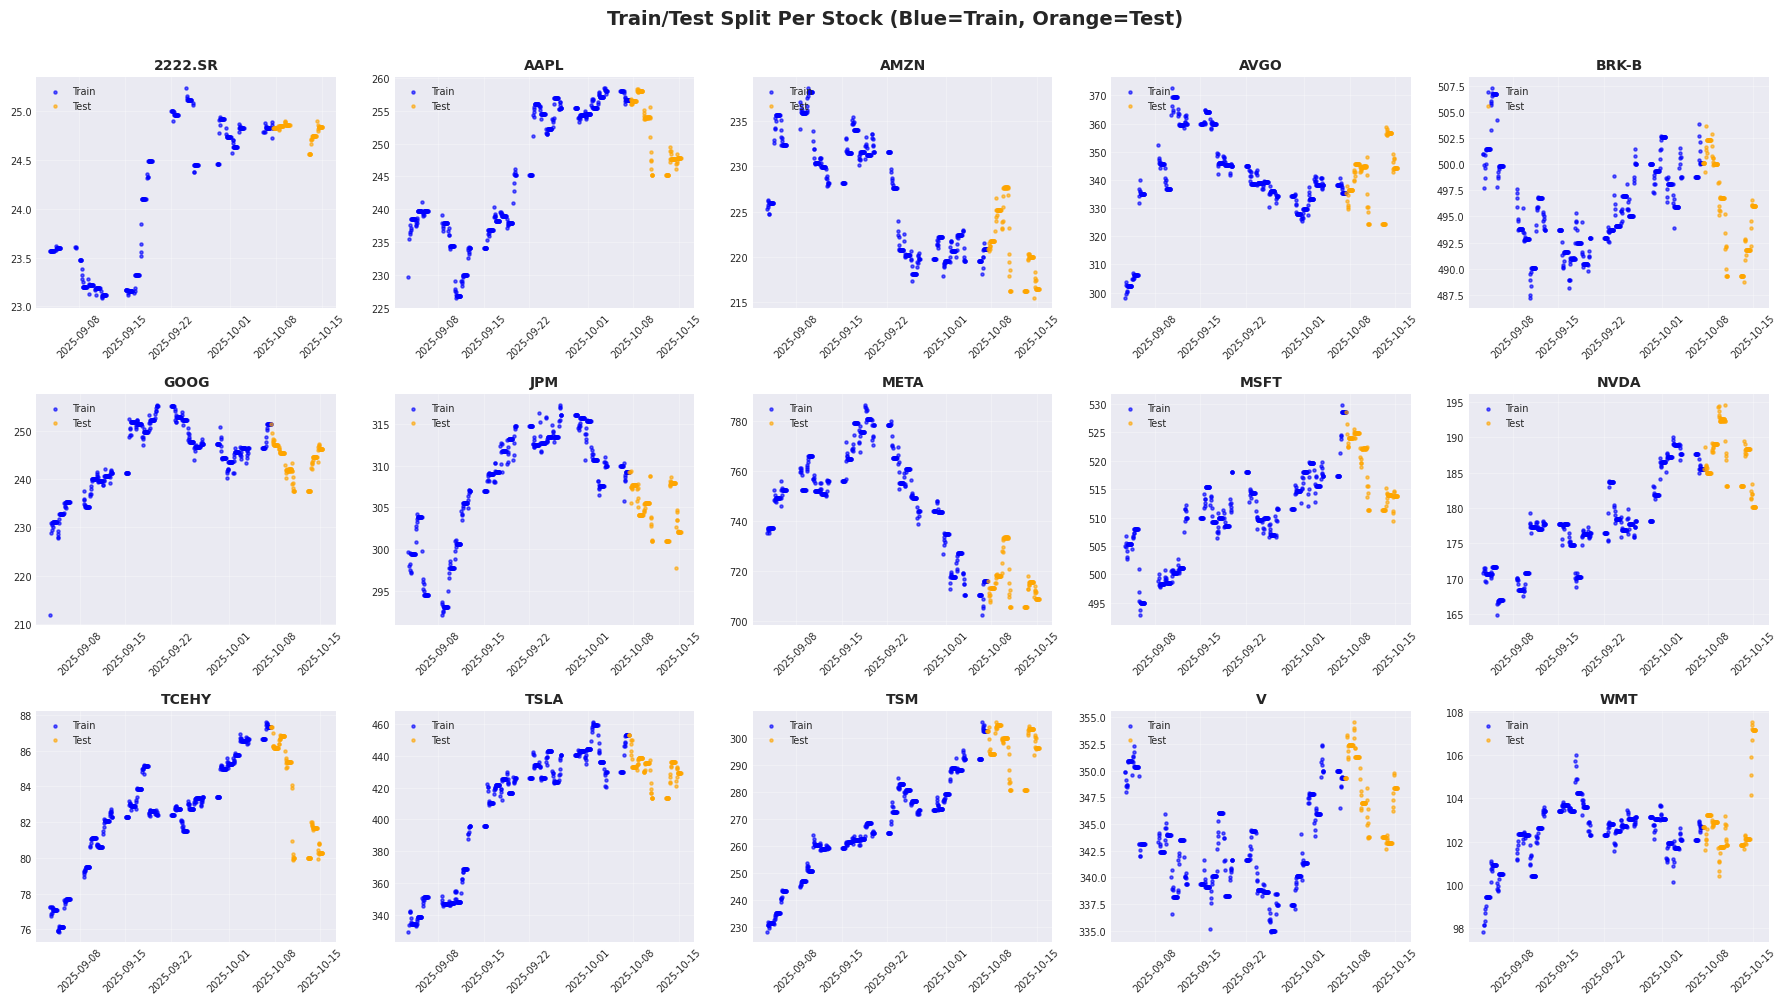

✅ Train/test split visualization complete


In [79]:
# Visualize the train/test split for each stock
fig, axes = plt.subplots(3, 5, figsize=(18, 10))
axes = axes.flatten()

for i, symbol in enumerate(df["symbol"].unique()):
    train_symbol = train_df[train_df["symbol"] == symbol]
    test_symbol = test_df[test_df["symbol"] == symbol]

    axes[i].scatter(
        train_symbol["timestamp"],
        train_symbol["close_price"],
        s=5,
        alpha=0.6,
        label="Train",
        color="blue",
    )
    axes[i].scatter(
        test_symbol["timestamp"],
        test_symbol["close_price"],
        s=5,
        alpha=0.6,
        label="Test",
        color="orange",
    )
    axes[i].set_title(f"{symbol}", fontsize=10, fontweight="bold")
    axes[i].tick_params(axis="x", rotation=45, labelsize=7)
    axes[i].tick_params(axis="y", labelsize=7)
    axes[i].legend(fontsize=7, loc="upper left")
    axes[i].grid(True, alpha=0.3)

plt.suptitle(
    "Train/Test Split Per Stock (Blue=Train, Orange=Test)",
    fontsize=14,
    fontweight="bold",
    y=1.00,
)
plt.tight_layout()
plt.show()

print("✅ Train/test split visualization complete")

## Prepare Features and Target

Separate features (X) from target variable (y) and scale the data.

In [80]:
# Define feature columns and target
target_col = "close_price"
metadata_cols = ["symbol", "timestamp"]
feature_cols = [col for col in df.columns if col not in [target_col] + metadata_cols]

print(f"Features ({len(feature_cols)}): {feature_cols}")
print(f"Target: {target_col}")

# Separate features and target
X_train = train_df[feature_cols].values
y_train = train_df[target_col].values

X_test = test_df[feature_cols].values
y_test = test_df[target_col].values

print(f"\nX_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Features (12): ['low', 'close_lag_1', 'sma_5', 'ema_5', 'bb_upper', 'rsi', 'volatility_20d', 'returns', 'volume', 'volume_lag_1', 'market_cap', 'day_of_month']
Target: close_price

X_train shape: (7155, 12)
y_train shape: (7155,)
X_test shape: (1800, 12)
y_test shape: (1800,)


In [81]:
# Scale features - important for neural networks and some ML models
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Scale target for neural networks (we'll inverse transform predictions)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

print("✅ Features and target scaled")

✅ Features and target scaled


## Evaluation Metrics

Define functions to calculate model performance metrics.

In [82]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    """Calculate regression metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"\n{'='*60}")
    print(f"{model_name} Performance")
    print(f"{'='*60}")
    print(f"RMSE:  ${rmse:,.2f}")
    print(f"MAE:   ${mae:,.2f}")
    print(f"R²:    {r2:.4f}")
    print(f"MAPE:  {mape:.2f}%")
    print(f"{'='*60}")

    return {"rmse": rmse, "mae": mae, "r2": r2, "mape": mape}


def plot_predictions(y_true, y_pred, model_name="Model", n_samples=200):
    """Plot actual vs predicted values"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot 1: Actual vs Predicted (scatter)
    axes[0].scatter(y_true[:n_samples], y_pred[:n_samples], alpha=0.5, s=20)
    axes[0].plot(
        [y_true.min(), y_true.max()],
        [y_true.min(), y_true.max()],
        "r--",
        lw=2,
        label="Perfect Prediction",
    )
    axes[0].set_xlabel("Actual Price ($)")
    axes[0].set_ylabel("Predicted Price ($)")
    axes[0].set_title(f"{model_name}: Actual vs Predicted")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Time series comparison (line)
    axes[1].plot(y_true[:n_samples], label="Actual", linewidth=2, alpha=0.7)
    axes[1].plot(y_pred[:n_samples], label="Predicted", linewidth=2, alpha=0.7)
    axes[1].set_xlabel("Sample Index")
    axes[1].set_ylabel("Price ($)")
    axes[1].set_title(
        f"{model_name}: Time Series Comparison (first {n_samples} samples)"
    )
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


print("✅ Evaluation functions defined")

✅ Evaluation functions defined


In [83]:
# Enhanced plotting function for multi-stock data
def plot_predictions_per_stock(
    y_true, y_pred, test_data, model_name="Model", stocks_to_plot=3
):
    """Plot actual vs predicted values for individual stocks"""
    # Select random stocks to visualize
    unique_stocks = test_data["symbol"].unique()
    np.random.seed(42)
    selected_stocks = np.random.choice(
        unique_stocks, min(stocks_to_plot, len(unique_stocks)), replace=False
    )

    fig, axes = plt.subplots(1, stocks_to_plot, figsize=(6 * stocks_to_plot, 4))
    if stocks_to_plot == 1:
        axes = [axes]

    for i, stock in enumerate(selected_stocks):
        stock_mask = test_data["symbol"] == stock
        stock_indices = test_data[stock_mask].index

        # Get predictions for this stock
        stock_actual = y_true[stock_mask]
        stock_pred = y_pred[stock_mask]
        stock_dates = test_data.loc[stock_indices, "timestamp"].values

        # Plot
        axes[i].plot(
            range(len(stock_actual)),
            stock_actual,
            label="Actual",
            linewidth=2,
            alpha=0.8,
            marker="o",
            markersize=4,
        )
        axes[i].plot(
            range(len(stock_pred)),
            stock_pred,
            label="Predicted",
            linewidth=2,
            alpha=0.8,
            marker="s",
            markersize=4,
        )

        axes[i].set_title(f"{model_name} - {stock}", fontweight="bold", fontsize=12)
        axes[i].set_xlabel("Time Step")
        axes[i].set_ylabel("Price ($)")
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

        # Calculate per-stock metrics
        rmse = np.sqrt(mean_squared_error(stock_actual, stock_pred))
        axes[i].text(
            0.02,
            0.98,
            f"RMSE: ${rmse:.2f}",
            transform=axes[i].transAxes,
            verticalalignment="top",
            bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
        )

    plt.tight_layout()
    plt.show()


print("✅ Enhanced per-stock plotting function defined")

✅ Enhanced per-stock plotting function defined


## Baseline Model 1: Naive Forecast

Predict tomorrow's price = today's price (using close_lag_1 feature)


Naive Forecast (Lag-1) Performance
RMSE:  $1.70
MAE:   $0.53
R²:    0.9999
MAPE:  0.17%


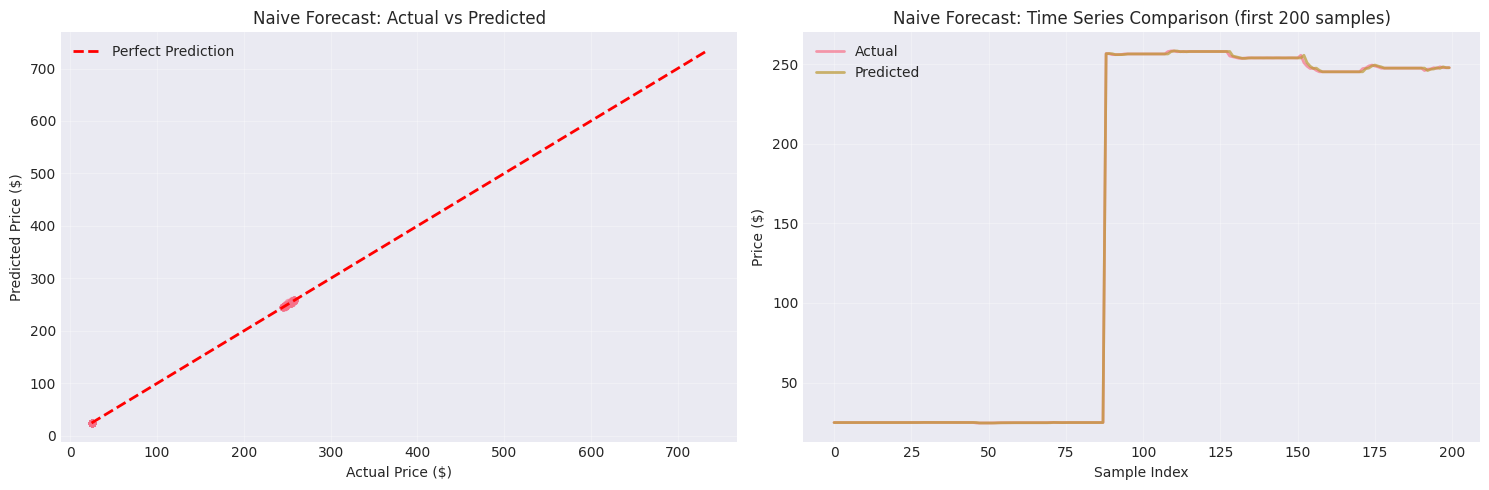

In [84]:
# Naive forecast: use lagged close price as prediction
if "close_lag_1" in feature_cols:
    lag_idx = feature_cols.index("close_lag_1")
    y_pred_naive = X_test[:, lag_idx]

    # Evaluate
    metrics_naive = evaluate_model(y_test, y_pred_naive, "Naive Forecast (Lag-1)")

    # Visualize
    plot_predictions(y_test, y_pred_naive, "Naive Forecast", n_samples=200)
else:
    print("❌ close_lag_1 feature not found")

## Baseline Model 2: Moving Average

Use SMA_5 feature as prediction


Moving Average (SMA-5) Performance
RMSE:  $1.89
MAE:   $0.73
R²:    0.9999
MAPE:  0.24%


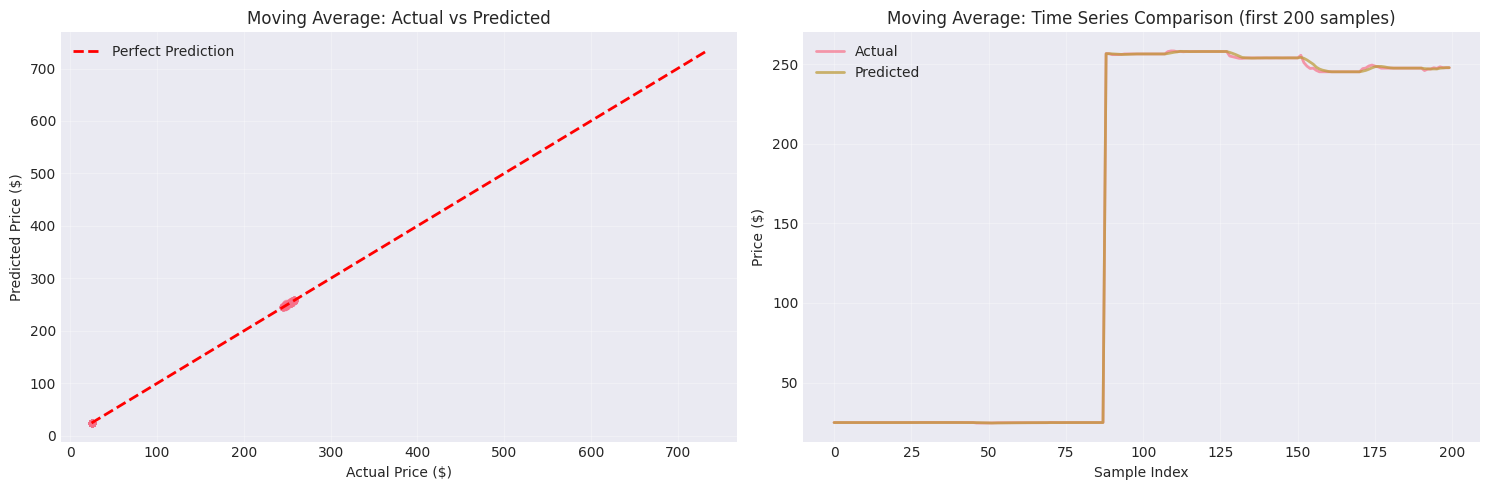

In [85]:
# Moving average forecast
if "sma_5" in feature_cols:
    sma_idx = feature_cols.index("sma_5")
    y_pred_ma = X_test[:, sma_idx]

    # Evaluate
    metrics_ma = evaluate_model(y_test, y_pred_ma, "Moving Average (SMA-5)")

    # Visualize
    plot_predictions(y_test, y_pred_ma, "Moving Average", n_samples=200)
else:
    print("❌ sma_5 feature not found")

## Model 3: Linear Regression

Simple linear model to establish a stronger baseline


Linear Regression Performance
RMSE:  $1.17
MAE:   $0.58
R²:    1.0000
MAPE:  0.26%


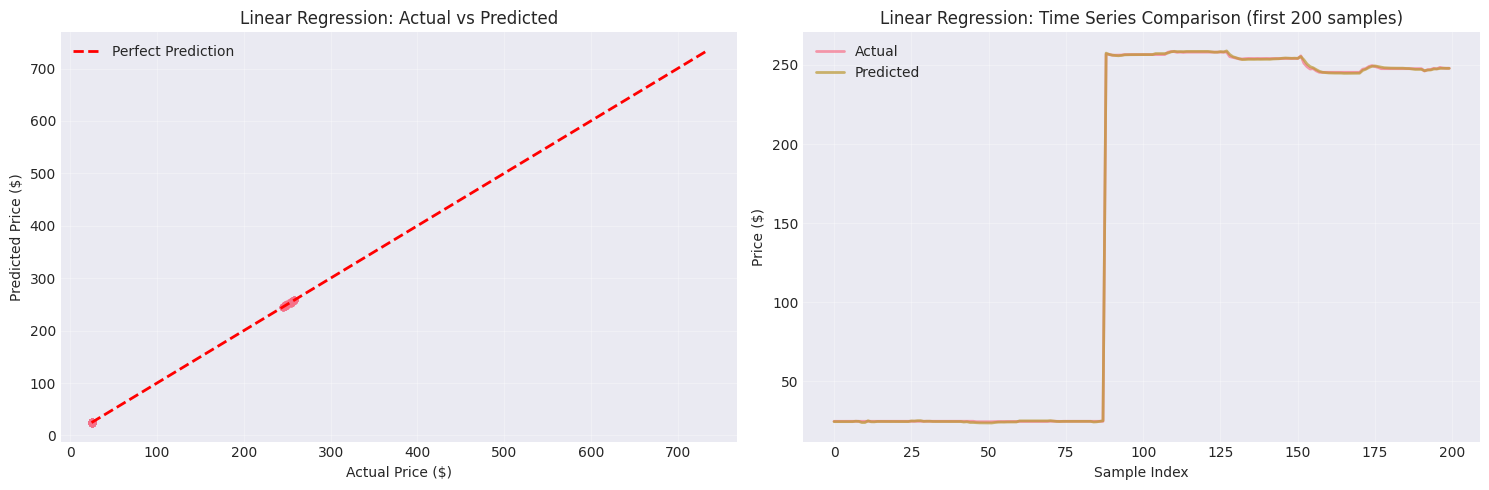


Top 5 Most Important Features:
       feature  coefficient
0          low     0.276293
1  close_lag_1     0.264961
3        ema_5     0.243039
2        sma_5     0.242608
4     bb_upper    -0.025804


In [86]:
# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test)

# Evaluate
metrics_lr = evaluate_model(y_test, y_pred_lr, "Linear Regression")

# Visualize
plot_predictions(y_test, y_pred_lr, "Linear Regression", n_samples=200)

# Feature importance (coefficients)
feature_importance = pd.DataFrame(
    {"feature": feature_cols, "coefficient": lr_model.coef_}
).sort_values("coefficient", key=abs, ascending=False)

print("\nTop 5 Most Important Features:")
print(feature_importance.head())

## Model 4: Random Forest

Ensemble model that can capture non-linear patterns

Training Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished



Random Forest Performance
RMSE:  $1.56
MAE:   $0.78
R²:    0.9999
MAPE:  0.28%


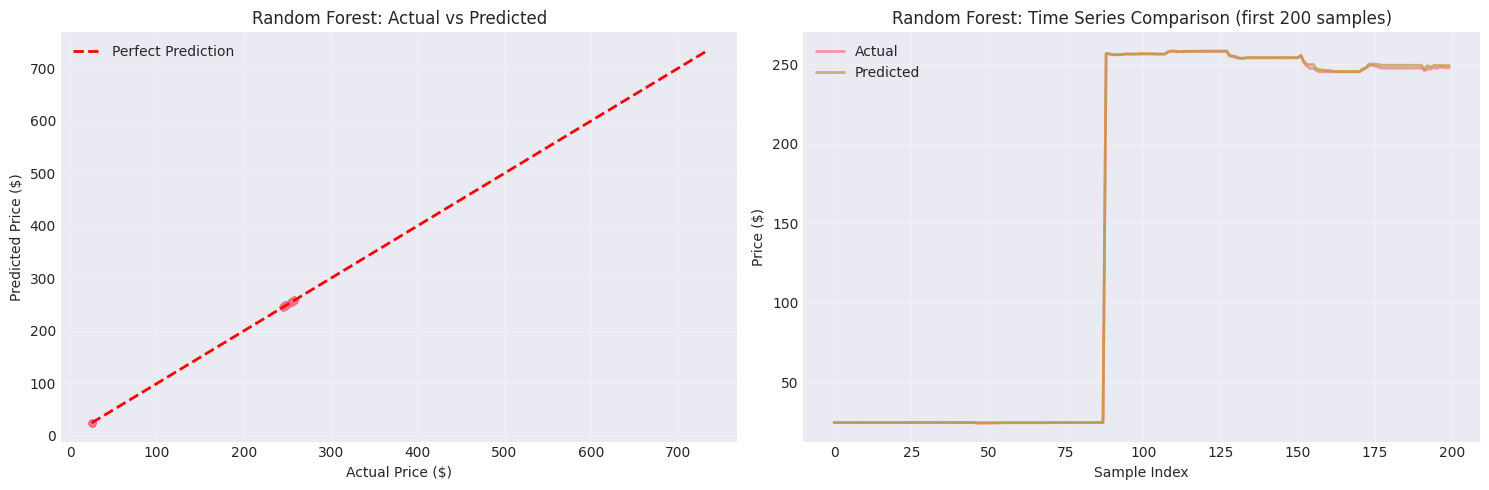


Top 5 Most Important Features:
       feature  importance
0          low    0.425253
4     bb_upper    0.197803
1  close_lag_1    0.128534
2        sma_5    0.128457
3        ema_5    0.117464


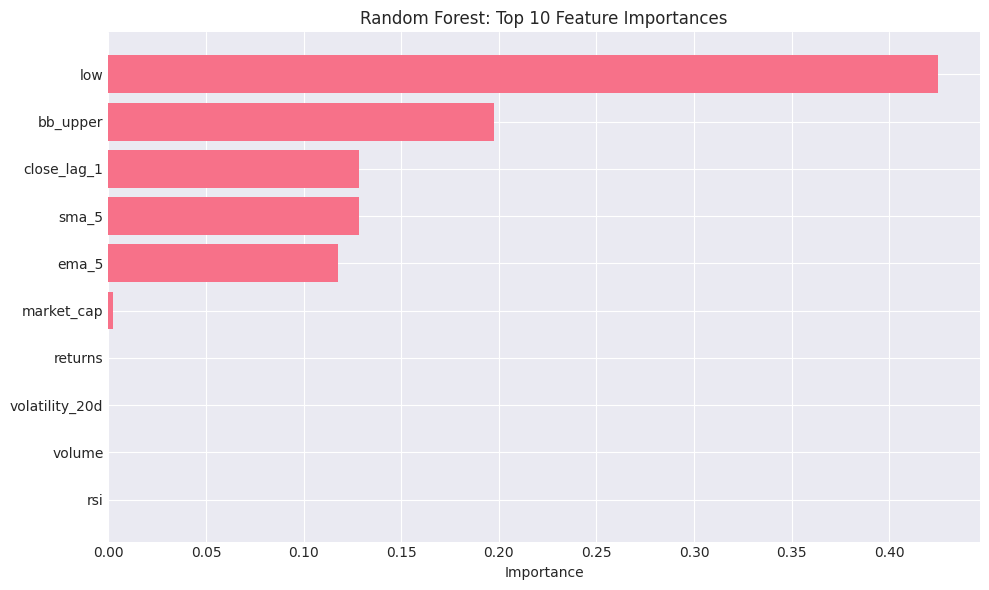

In [87]:
# Train Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1,
    verbose=1,
)

print("Training Random Forest...")
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Evaluate
metrics_rf = evaluate_model(y_test, y_pred_rf, "Random Forest")

# Visualize
plot_predictions(y_test, y_pred_rf, "Random Forest", n_samples=200)

# Feature importance
rf_importance = pd.DataFrame(
    {"feature": feature_cols, "importance": rf_model.feature_importances_}
).sort_values("importance", ascending=False)

print("\nTop 5 Most Important Features:")
print(rf_importance.head())

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(rf_importance["feature"][:10], rf_importance["importance"][:10])
plt.xlabel("Importance")
plt.title("Random Forest: Top 10 Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Model Comparison

Compare all models side by side


MODEL COMPARISON SUMMARY
            Model     RMSE      MAE       R²  MAPE (%)
Linear Regression 1.174915 0.579556 0.999954  0.258404
    Random Forest 1.558631 0.782043 0.999919  0.277340
   Naive Forecast 1.696045 0.533556 0.999905  0.174781
   Moving Average 1.888519 0.725008 0.999882  0.239002


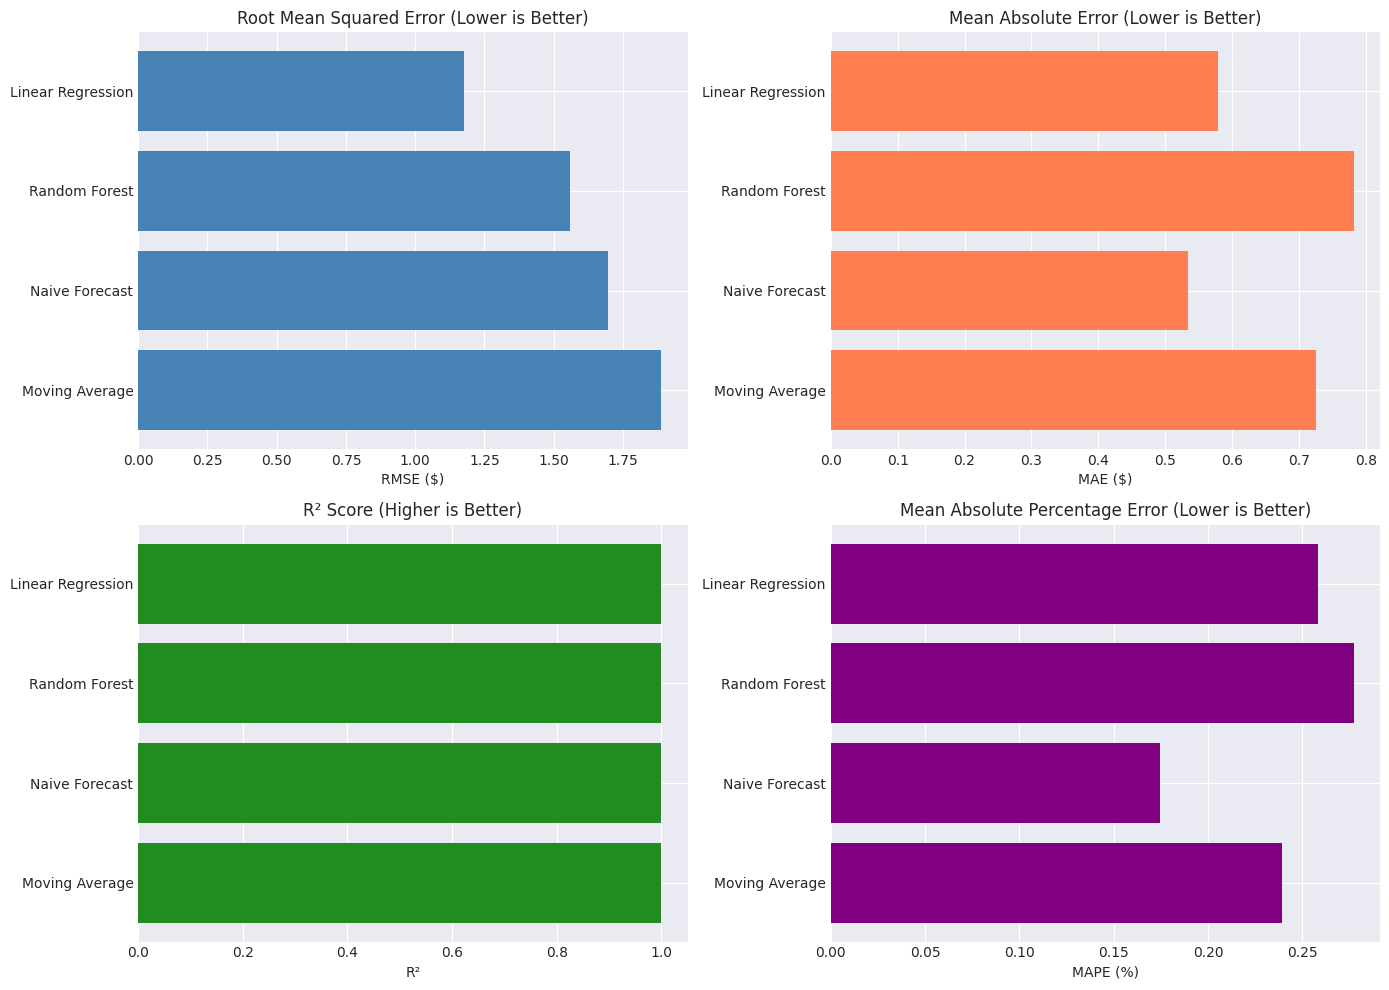


✅ Best Model (by RMSE): Linear Regression


In [89]:
# Compile results
results_df = pd.DataFrame(
    {
        "Model": [
            "Naive Forecast",
            "Moving Average",
            "Linear Regression",
            "Random Forest",
        ],
        "RMSE": [
            metrics_naive["rmse"],
            metrics_ma["rmse"],
            metrics_lr["rmse"],
            metrics_rf["rmse"],
        ],
        "MAE": [
            metrics_naive["mae"],
            metrics_ma["mae"],
            metrics_lr["mae"],
            metrics_rf["mae"],
        ],
        "R²": [
            metrics_naive["r2"],
            metrics_ma["r2"],
            metrics_lr["r2"],
            metrics_rf["r2"],
        ],
        "MAPE (%)": [
            metrics_naive["mape"],
            metrics_ma["mape"],
            metrics_lr["mape"],
            metrics_rf["mape"],
        ],
    }
)

results_df = results_df.sort_values("RMSE")
print("\n" + "=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)
print(results_df.to_string(index=False))
print("=" * 80)

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# RMSE
axes[0, 0].barh(results_df["Model"], results_df["RMSE"], color="steelblue")
axes[0, 0].set_xlabel("RMSE ($)")
axes[0, 0].set_title("Root Mean Squared Error (Lower is Better)")
axes[0, 0].invert_yaxis()

# MAE
axes[0, 1].barh(results_df["Model"], results_df["MAE"], color="coral")
axes[0, 1].set_xlabel("MAE ($)")
axes[0, 1].set_title("Mean Absolute Error (Lower is Better)")
axes[0, 1].invert_yaxis()

# R²
axes[1, 0].barh(results_df["Model"], results_df["R²"], color="forestgreen")
axes[1, 0].set_xlabel("R²")
axes[1, 0].set_title("R² Score (Higher is Better)")
axes[1, 0].invert_yaxis()

# MAPE
axes[1, 1].barh(results_df["Model"], results_df["MAPE (%)"], color="purple")
axes[1, 1].set_xlabel("MAPE (%)")
axes[1, 1].set_title("Mean Absolute Percentage Error (Lower is Better)")
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

# Identify best model
best_model = results_df.iloc[0]["Model"]
print(f"\n✅ Best Model (by RMSE): {best_model}")

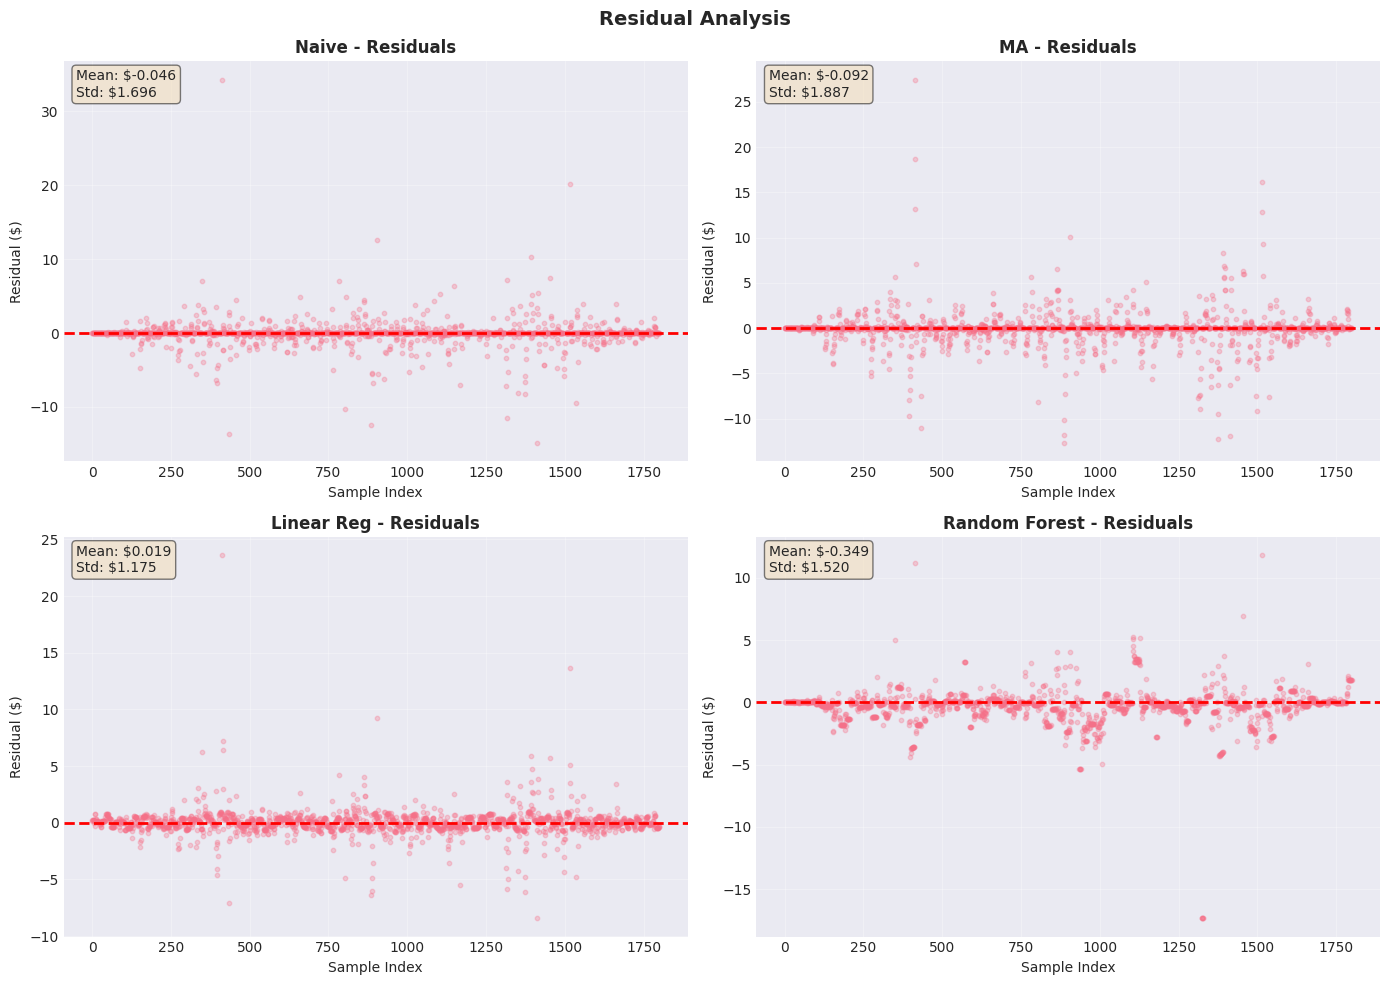

Residual Statistics:
          Naive        MA  Linear Reg  Random Forest
count  1800.000  1800.000    1800.000       1800.000
mean     -0.046    -0.092       0.019         -0.349
std       1.696     1.887       1.175          1.520
min     -14.880   -12.686      -8.446        -17.361
25%       0.000    -0.061      -0.366         -0.612
50%       0.000     0.000       0.026         -0.154
75%       0.000     0.012       0.378          0.056
max      34.330    27.464      23.621         11.828


In [90]:
# Analyze residuals (prediction errors)
residuals_df = pd.DataFrame(
    {
        "Naive": y_test - y_pred_naive,
        "MA": y_test - y_pred_ma,
        "Linear Reg": y_test - y_pred_lr,
        "Random Forest": y_test - y_pred_rf,
    }
)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(residuals_df.columns):
    # Residual plot
    axes[i].scatter(range(len(residuals_df)), residuals_df[col], alpha=0.3, s=10)
    axes[i].axhline(0, color="red", linestyle="--", linewidth=2)
    axes[i].set_title(f"{col} - Residuals", fontweight="bold")
    axes[i].set_xlabel("Sample Index")
    axes[i].set_ylabel("Residual ($)")
    axes[i].grid(True, alpha=0.3)

    # Add statistics
    mean_res = residuals_df[col].mean()
    std_res = residuals_df[col].std()
    axes[i].text(
        0.02,
        0.98,
        f"Mean: ${mean_res:.3f}\nStd: ${std_res:.3f}",
        transform=axes[i].transAxes,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
    )

plt.suptitle("Residual Analysis", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

print("Residual Statistics:")
print(residuals_df.describe().round(3))

Prediction Statistics Comparison:

----------------------------------------------------------------------
                 Mean     Std    Min     Max   Range
Actual         309.88  173.66  24.56  733.51  708.95
Naive          309.92  173.68  24.56  733.51  708.95
MA             309.97  173.70  24.56  733.43  708.87
Linear Reg     309.86  173.66  23.78  733.94  710.16
Random Forest  310.23  173.90  24.58  734.73  710.16


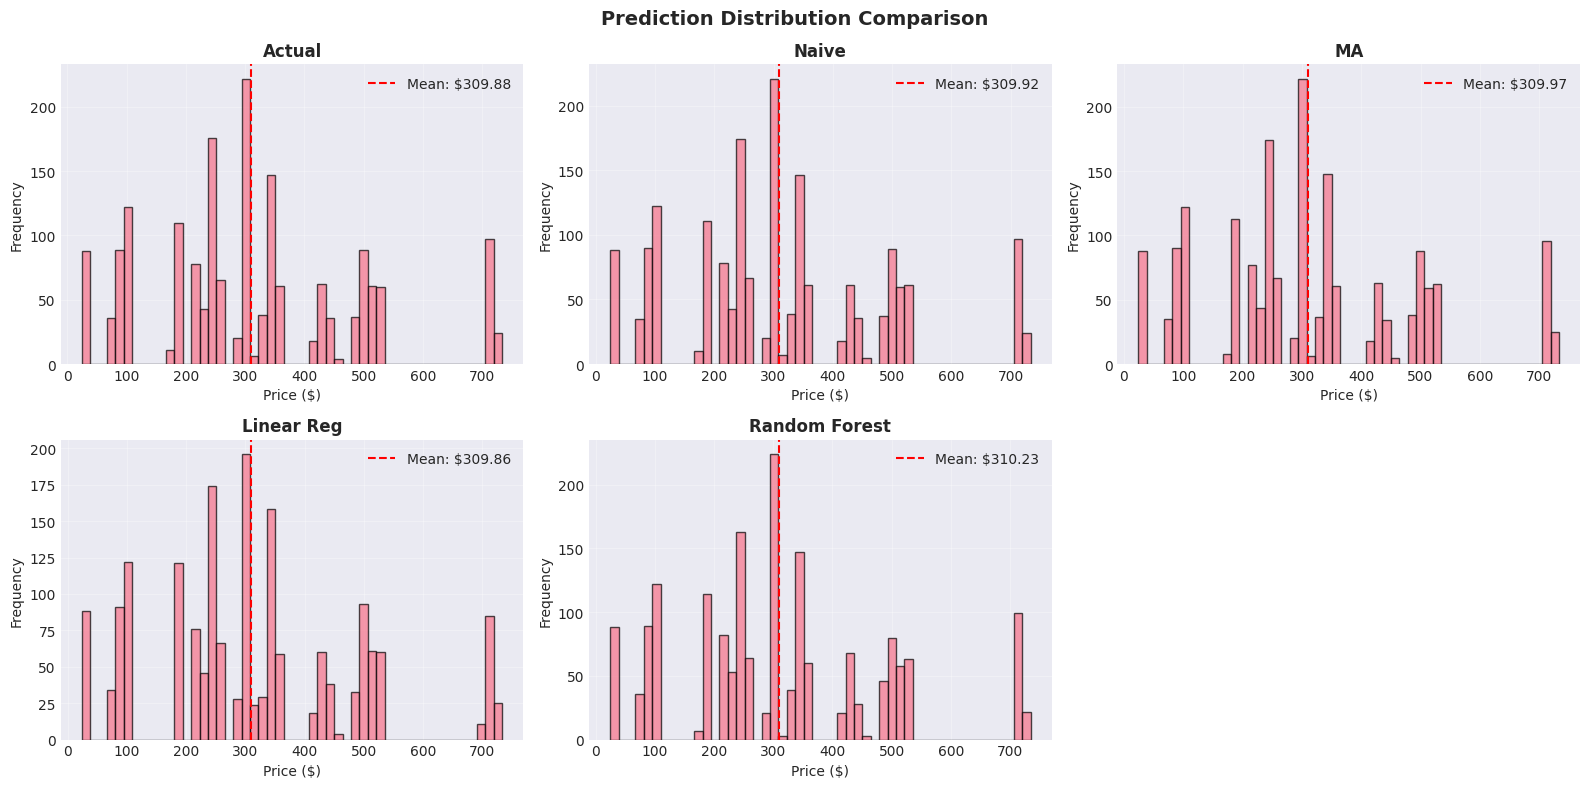


✅ Diagnostic analysis complete


In [91]:
# Check prediction distributions
print("Prediction Statistics Comparison:\n")
print("-" * 70)

models_preds = {
    "Actual": y_test,
    "Naive": y_pred_naive,
    "MA": y_pred_ma,
    "Linear Reg": y_pred_lr,
    "Random Forest": y_pred_rf,
}

stats_df = pd.DataFrame(
    {
        name: {
            "Mean": preds.mean(),
            "Std": preds.std(),
            "Min": preds.min(),
            "Max": preds.max(),
            "Range": preds.max() - preds.min(),
        }
        for name, preds in models_preds.items()
    }
).T

print(stats_df.round(2))

# Visualize prediction distributions
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

for i, (name, preds) in enumerate(models_preds.items()):
    axes[i].hist(preds, bins=50, alpha=0.7, edgecolor="black")
    axes[i].axvline(
        preds.mean(), color="red", linestyle="--", label=f"Mean: ${preds.mean():.2f}"
    )
    axes[i].set_title(name, fontweight="bold")
    axes[i].set_xlabel("Price ($)")
    axes[i].set_ylabel("Frequency")
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

# Hide the last subplot
axes[-1].set_visible(False)

plt.suptitle("Prediction Distribution Comparison", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

print("\n✅ Diagnostic analysis complete")

In [92]:
# Analyze relationship between stock characteristics and prediction accuracy
analysis_df = lr_per_stock.copy()

# Create scatter plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: RMSE vs Average Price
axes[0].scatter(
    analysis_df["Avg Price"],
    analysis_df["RMSE"],
    s=100,
    alpha=0.6,
    c=analysis_df["MAPE (%)"],
    cmap="viridis",
)
for _, row in analysis_df.iterrows():
    axes[0].annotate(
        row["Symbol"], (row["Avg Price"], row["RMSE"]), fontsize=8, alpha=0.7
    )
axes[0].set_xlabel("Average Price ($)")
axes[0].set_ylabel("RMSE ($)")
axes[0].set_title("RMSE vs Stock Price", fontweight="bold")
axes[0].grid(True, alpha=0.3)

# Plot 2: RMSE vs Price Volatility
axes[1].scatter(
    analysis_df["Price Std"],
    analysis_df["RMSE"],
    s=100,
    alpha=0.6,
    c=analysis_df["MAPE (%)"],
    cmap="viridis",
)
for _, row in analysis_df.iterrows():
    axes[1].annotate(
        row["Symbol"], (row["Price Std"], row["RMSE"]), fontsize=8, alpha=0.7
    )
axes[1].set_xlabel("Price Std Dev ($)")
axes[1].set_ylabel("RMSE ($)")
axes[1].set_title("RMSE vs Price Volatility", fontweight="bold")
axes[1].grid(True, alpha=0.3)

# Plot 3: Normalized Error (RMSE/Price %) Distribution
axes[2].barh(
    analysis_df["Symbol"], analysis_df["RMSE/Price (%)"], color="teal", alpha=0.7
)
axes[2].axvline(
    analysis_df["RMSE/Price (%)"].mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean: {analysis_df['RMSE/Price (%)'].mean():.2f}%",
)
axes[2].set_xlabel("Normalized Error (%)")
axes[2].set_title("Normalized Prediction Error", fontweight="bold")
axes[2].invert_yaxis()
axes[2].legend()
axes[2].grid(True, alpha=0.3, axis="x")

plt.suptitle(
    "Stock Characteristics vs Prediction Accuracy", fontsize=14, fontweight="bold"
)
plt.tight_layout()
plt.show()

# Calculate correlations
print("\n" + "=" * 80)
print("CORRELATION ANALYSIS")
print("=" * 80)
print(
    f"Correlation between Average Price and RMSE:      {analysis_df['Avg Price'].corr(analysis_df['RMSE']):.4f}"
)
print(
    f"Correlation between Price Volatility and RMSE:   {analysis_df['Price Std'].corr(analysis_df['RMSE']):.4f}"
)
print(
    f"Correlation between Average Price and MAPE:      {analysis_df['Avg Price'].corr(analysis_df['MAPE (%)']):.4f}"
)
print("=" * 80)

print(f"\n💡 Key Insights:")
if analysis_df["Avg Price"].corr(analysis_df["RMSE"]) > 0.7:
    print(f"   ✅ Higher-priced stocks have proportionally higher RMSE (expected)")
else:
    print(f"   ℹ️  Weak correlation between price and RMSE")

if analysis_df["Price Std"].corr(analysis_df["RMSE"]) > 0.5:
    print(f"   ✅ More volatile stocks are harder to predict (expected)")
else:
    print(f"   ℹ️  Volatility doesn't strongly affect prediction accuracy")

avg_normalized_error = analysis_df["RMSE/Price (%)"].mean()
if avg_normalized_error < 1.0:
    print(
        f"   🎯 Excellent! Average error is only {avg_normalized_error:.2f}% of stock price"
    )
elif avg_normalized_error < 2.0:
    print(f"   ✅ Good! Average error is {avg_normalized_error:.2f}% of stock price")
else:
    print(f"   ⚠️  Average error is {avg_normalized_error:.2f}% - room for improvement")

NameError: name 'lr_per_stock' is not defined

In [ ]:
# Visualize predictions for specific stocks (best, worst, median)
best_stock = lr_per_stock.iloc[0]["Symbol"]
worst_stock = lr_per_stock.iloc[-1]["Symbol"]
median_idx = len(lr_per_stock) // 2
median_stock = lr_per_stock.iloc[median_idx]["Symbol"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (stock, title) in enumerate(
    [
        (best_stock, f"Best: {best_stock}"),
        (median_stock, f"Median: {median_stock}"),
        (worst_stock, f"Worst: {worst_stock}"),
    ]
):
    stock_mask = test_df["symbol"] == stock
    stock_actual = y_test[stock_mask]
    stock_pred_lr = y_pred_lr[stock_mask]
    stock_dates = test_df[stock_mask]["timestamp"].values

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(stock_actual, stock_pred_lr))
    r2 = r2_score(stock_actual, stock_pred_lr)

    # Plot
    axes[i].plot(
        range(len(stock_actual)),
        stock_actual,
        label="Actual",
        linewidth=2.5,
        alpha=0.8,
        marker="o",
        markersize=5,
    )
    axes[i].plot(
        range(len(stock_pred_lr)),
        stock_pred_lr,
        label="Predicted",
        linewidth=2.5,
        alpha=0.8,
        marker="s",
        markersize=5,
    )

    axes[i].set_title(
        f"{title}\nRMSE: ${rmse:.2f} | R²: {r2:.4f}", fontweight="bold", fontsize=12
    )
    axes[i].set_xlabel("Time Step")
    axes[i].set_ylabel("Price ($)")
    axes[i].legend(fontsize=10)
    axes[i].grid(True, alpha=0.3)

plt.suptitle(
    "Linear Regression: Best vs Median vs Worst Stock Performance",
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

In [ ]:
# Compare models across stocks
# Create pivot table for RMSE comparison
rmse_pivot = all_per_stock.pivot(index="Symbol", columns="Model", values="RMSE")
rmse_pivot = rmse_pivot.sort_values("Linear Reg")

print("\n" + "=" * 80)
print("MODEL COMPARISON: RMSE BY STOCK")
print("=" * 80)
print(rmse_pivot.round(2).to_string())
print("=" * 80)

# Find which model performs best for each stock
best_model_per_stock = all_per_stock.loc[
    all_per_stock.groupby("Symbol")["RMSE"].idxmin()
]
best_model_per_stock = best_model_per_stock.sort_values("Symbol")

print("\n📊 Best Model Per Stock:")
print("-" * 80)
for _, row in best_model_per_stock.iterrows():
    print(f"   {row['Symbol']:6s} → {row['Model']:12s} (RMSE: ${row['RMSE']:.2f})")
print("-" * 80)

# Count which model wins most often
model_wins = best_model_per_stock["Model"].value_counts()
print(f"\n🏆 Model Win Count:")
for model, count in model_wins.items():
    print(
        f"   {model:12s}: {count} stocks ({count/len(best_model_per_stock)*100:.1f}%)"
    )

In [ ]:
# Visualize per-stock performance
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: RMSE by stock
axes[0, 0].barh(lr_per_stock["Symbol"], lr_per_stock["RMSE"], color="steelblue")
axes[0, 0].set_xlabel("RMSE ($)")
axes[0, 0].set_title("RMSE by Stock (Linear Regression)", fontweight="bold")
axes[0, 0].invert_yaxis()
axes[0, 0].grid(True, alpha=0.3, axis="x")

# Plot 2: MAPE by stock
axes[0, 1].barh(lr_per_stock["Symbol"], lr_per_stock["MAPE (%)"], color="coral")
axes[0, 1].set_xlabel("MAPE (%)")
axes[0, 1].set_title("Mean Absolute Percentage Error by Stock", fontweight="bold")
axes[0, 1].invert_yaxis()
axes[0, 1].grid(True, alpha=0.3, axis="x")

# Plot 3: R² by stock
axes[1, 0].barh(lr_per_stock["Symbol"], lr_per_stock["R²"], color="forestgreen")
axes[1, 0].set_xlabel("R² Score")
axes[1, 0].set_title("R² Score by Stock (Higher is Better)", fontweight="bold")
axes[1, 0].invert_yaxis()
axes[1, 0].grid(True, alpha=0.3, axis="x")

# Plot 4: Normalized error (RMSE/Price %)
axes[1, 1].barh(lr_per_stock["Symbol"], lr_per_stock["RMSE/Price (%)"], color="purple")
axes[1, 1].set_xlabel("Normalized Error (%)")
axes[1, 1].set_title("RMSE as % of Average Price", fontweight="bold")
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3, axis="x")

plt.suptitle(
    "Per-Stock Performance Analysis (Linear Regression)",
    fontsize=14,
    fontweight="bold",
    y=1.00,
)
plt.tight_layout()
plt.show()

In [ ]:
# Focus on Linear Regression (best model) - show per-stock performance
lr_per_stock = all_per_stock[all_per_stock["Model"] == "Linear Reg"].sort_values("RMSE")

print("\n" + "=" * 80)
print("LINEAR REGRESSION: PER-STOCK PERFORMANCE")
print("=" * 80)
print(
    lr_per_stock[
        ["Symbol", "RMSE", "MAE", "MAPE (%)", "R²", "Avg Price", "RMSE/Price (%)"]
    ].to_string(index=False)
)
print("=" * 80)

# Summary statistics
print(f"\n📊 Summary Statistics:")
print(
    f"   Best Stock (lowest RMSE):  {lr_per_stock.iloc[0]['Symbol']} - ${lr_per_stock.iloc[0]['RMSE']:.2f}"
)
print(
    f"   Worst Stock (highest RMSE): {lr_per_stock.iloc[-1]['Symbol']} - ${lr_per_stock.iloc[-1]['RMSE']:.2f}"
)
print(f"   Mean RMSE across stocks:    ${lr_per_stock['RMSE'].mean():.2f}")
print(f"   Median RMSE across stocks:  ${lr_per_stock['RMSE'].median():.2f}")
print(f"   Mean MAPE across stocks:    {lr_per_stock['MAPE (%)'].mean():.2f}%")
print(f"   Mean R² across stocks:      {lr_per_stock['R²'].mean():.4f}")

In [ ]:
# Calculate per-stock metrics for each model
def calculate_per_stock_metrics(y_true, y_pred, test_data, model_name):
    """Calculate RMSE, MAE, and MAPE for each stock"""
    results = []

    for symbol in test_data["symbol"].unique():
        stock_mask = test_data["symbol"] == symbol
        stock_actual = y_true[stock_mask]
        stock_pred = y_pred[stock_mask]

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(stock_actual, stock_pred))
        mae = mean_absolute_error(stock_actual, stock_pred)
        mape = np.mean(np.abs((stock_actual - stock_pred) / stock_actual)) * 100
        r2 = r2_score(stock_actual, stock_pred)

        # Get price statistics
        avg_price = stock_actual.mean()
        price_std = stock_actual.std()

        results.append(
            {
                "Symbol": symbol,
                "Model": model_name,
                "RMSE": rmse,
                "MAE": mae,
                "MAPE (%)": mape,
                "R²": r2,
                "Avg Price": avg_price,
                "Price Std": price_std,
                "Samples": len(stock_actual),
                "RMSE/Price (%)": (rmse / avg_price) * 100,  # Normalized error
            }
        )

    return pd.DataFrame(results)


# Calculate for all models
print("Calculating per-stock performance for all models...")
print("=" * 80)

per_stock_results = []

per_stock_results.append(
    calculate_per_stock_metrics(y_test, y_pred_naive, test_df, "Naive")
)
per_stock_results.append(
    calculate_per_stock_metrics(y_test, y_pred_ma, test_df, "Moving Avg")
)
per_stock_results.append(
    calculate_per_stock_metrics(y_test, y_pred_lr, test_df, "Linear Reg")
)
per_stock_results.append(
    calculate_per_stock_metrics(y_test, y_pred_rf, test_df, "Random Forest")
)

all_per_stock = pd.concat(per_stock_results, ignore_index=True)

print("✅ Per-stock metrics calculated for all models")
print(f"   Total stocks analyzed: {all_per_stock['Symbol'].nunique()}")
print(f"   Models compared: {all_per_stock['Model'].nunique()}")

## 📊 Per-Stock Performance Analysis

Let's evaluate how accurately each model predicts prices for individual stocks.